In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gc
import glob
import io
import IPython
import json
import numpy as np
import pathlib
import pandas as pd
import sys
import cv2
import math
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

from PIL import Image
import tensorflow as tf

INPUT_DIR = '/kaggle/input/tensorflow-great-barrier-reef/'
sys.path.insert(0, INPUT_DIR)
import greatbarrierreef

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.6.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Install TF Object Detection API & Download Pre-Trained Model

Created folders:
1. **api**: for storing tensorflow object detection model api files
2. **pre-trained-models**: for storing downloaded pretrained models including checkpoints and config
3. **my_models**: for storing trained model and new config
4. **data**: for storing tfrecords files and `label_map.pbtxt` file

## Create Configs and Folders 

In [3]:
CUSTOM_MODEL_NAME = 'my_efficientdet_d2' 
PRETRAINED_MODEL_NAME = 'efficientdet_d2_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
folders = {
    'APIMODEL_PATH': 'api',
    'DATA_PATH': 'data',
    'MODEL_PATH': 'my_models',
    'PRETRAINED_MODEL_PATH': 'pre-trained-models',
    'CHECKPOINT_PATH': os.path.join('my_models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('my_models',CUSTOM_MODEL_NAME, 'export')
}

files = {
    'PIPELINE_CONFIG':os.path.join(folders['MODEL_PATH'], CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(folders['DATA_PATH'], LABEL_MAP_NAME),
    'VERIFICATION_SCRIPT': os.path.join(folders['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py'),
    'TRAINING_SCRIPT': os.path.join(folders['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py'),
    'EXPORTER_SCRIPT': os.path.join(folders['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py')
}

In [5]:
for path in folders.values():
    if not os.path.exists(path):
        !mkdir -p {path}

## Download Pre-Trained Model

In [6]:
!wget {PRETRAINED_MODEL_URL} -P {folders['PRETRAINED_MODEL_PATH']}
!cd {folders['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2021-12-20 10:10:16--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.216.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62929273 (60M) [application/x-tar]
Saving to: ‘pre-trained-models/efficientdet_d2_coco17_tpu-32.tar.gz’

efficientdet_d2_coc 100%[===================>]  60.01M  83.2MB/s    in 0.7s    

2021-12-20 10:10:18 (83.2 MB/s) - ‘pre-trained-models/efficientdet_d2_coco17_tpu-32.tar.gz’ saved [62929273/62929273]

efficientdet_d2_coco17_tpu-32/
efficientdet_d2_coco17_tpu-32/checkpoint/
efficientdet_d2_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d2_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d2_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d2_coco17_tpu-32/pipeline.config
efficientdet_d2_

## Download TFODT API

In [7]:
if not os.path.exists(os.path.join(folders['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {folders['APIMODEL_PATH']}

Cloning into 'api'...
remote: Enumerating objects: 68117, done.
remote: Total 68117 (delta 0), reused 0 (delta 0), pack-reused 68117
Receiving objects: 100% (68117/68117), 576.45 MiB | 29.66 MiB/s, done.
Resolving deltas: 100% (47843/47843), done.


## Install TFODT API

In [8]:
%%bash
cd api/research

protoc object_detection/protos/*.proto --python_out=.

# cp object_detection/packages/tf2/setup.py .
wget https://storage.googleapis.com/odml-dataset/others/setup.py
pip install -q --user .

pip install -q imagesize

--2021-12-20 10:10:45--  https://storage.googleapis.com/odml-dataset/others/setup.py
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.141.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1401 (1.4K) [text/x-python]
Saving to: ‘setup.py’

     0K .                                                     100% 14.9M=0s

2021-12-20 10:10:45 (14.9 MB/s) - ‘setup.py’ saved [1401/1401]

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Consider adding this directory to PATH or, if you prefer to 

In [9]:
! python {files['VERIFICATION_SCRIPT']}

Running tests under Python 3.7.10: /opt/conda/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
/root/.local/lib/python3.7/site-packages/object_detection/builders/model_builder.py:1100: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(('Building experimental DeepMAC meta-arch.'
W1220 10:11:40.190690 139865333139264 model_builder.py:1100] Building experimental DeepMAC meta-arch. Some features may be omitted.
I1220 10:11:40.473055 139865333139264 test_util.py:2189] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.49s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
I1220 10:11:41.177425 139865333139264 test_util.py:2189] time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.7s
[       OK ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head

## Import TFODT API

In [10]:
from object_detection.utils import dataset_util, label_map_util, config_util

from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
import imagesize

# Prepare Data

## Split Dataset

In [11]:
TRAINING_RATIO = 0.8
data_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))

In [12]:
split_index = int(TRAINING_RATIO * len(data_df))

while data_df.iloc[split_index - 1].sequence == data_df.iloc[split_index].sequence:
    split_index += 1

train_data_df = data_df.iloc[:split_index].sample(frac=1).reset_index(drop=True)
val_data_df = data_df.iloc[split_index:].sample(frac=1).reset_index(drop=True)

train_positive_count = len(train_data_df[train_data_df.annotations != '[]'])
val_positive_count = len(val_data_df[val_data_df.annotations != '[]'])

print('Training ratio (all samples):', f"{(float(len(train_data_df)) / (len(train_data_df) + len(val_data_df))):.2f}")
print('Training ratio (positive samples):', f"{(float(train_positive_count) / (train_positive_count + val_positive_count)):.2f}")

Training ratio (all samples): 0.82
Training ratio (positive samples): 0.87


In [13]:
train_data_df = train_data_df[train_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for training:', len(train_data_df))
val_data_df = val_data_df[val_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for validation:', len(val_data_df))

Number of positive images used for training: 4271
Number of positive images used for validation: 648


In [14]:
train_data_df.head()

index  video_id  sequence  video_frame  sequence_frame image_id  \
0      2         1     60754         9068             652   1-9068   
1      9         1      8503         3891              63   1-3891   
2     11         0     53708         8968              83   0-8968   
3     13         0       996        11878             453  0-11878   
4     25         0     45518          882               9    0-882   

                                         annotations  
0  [{'x': 464, 'y': 492, 'width': 52, 'height': 4...  
1    [{'x': 148, 'y': 0, 'width': 50, 'height': 21}]  
2  [{'x': 1082, 'y': 685, 'width': 36, 'height': ...  
3   [{'x': 898, 'y': 32, 'width': 61, 'height': 42}]  
4  [{'x': 712, 'y': 624, 'width': 51, 'height': 38}]

## Helper Functions

In [15]:
def load_image_into_np(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(io.BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np, boxes, classes, scores, category_index, unc=True):
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(image_np_with_annotations,
                                                       boxes,
                                                       classes,
                                                       scores,
                                                       category_index,
                                                       use_normalized_coordinates=unc,
                                                       min_score_thresh=0.05)
    return image_np_with_annotations

def get_image_with_annotation(df, idx):
    row = df.iloc[idx]
    img = load_image_into_np(row.image_path)
    boxes = np.asarray(row.bboxes)
    num_boxes = len(boxes)
    classes = np.ones(num_boxes, dtype='int32')
    scores = np.ones(num_boxes)
    category_index = {1: {'id': 1, 'name': 'COTS'}}
    unc = True
    
    img = plot_detections(img, boxes, classes, scores, category_index, unc)
    return img


def get_bbox(row):
    bboxes = []
    annotations = json.loads(row.annotations.replace("'", '"'))
    for annotation in annotations:
            bboxes.append([annotation['y'] / row.height, 
                           annotation['x'] / row.width,
                           (annotation['y'] + annotation['height']) / row.height, 
                           (annotation['x'] + annotation['width']) / row.width])
    row["bboxes"] = bboxes
    return row

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row["image_path"])
    return row

def get_path(row):
    row["image_path"] = os.path.join(INPUT_DIR, "train_images", f'video_{row.video_id}', f'{row.video_frame}.jpg')
    return row

## Add Some Useful Columns

In [16]:
train_data_df = train_data_df.progress_apply(get_path,axis=1)
val_data_df = val_data_df.progress_apply(get_path,axis=1)

train_data_df = train_data_df.progress_apply(get_imgsize,axis=1)
val_data_df = val_data_df.progress_apply(get_imgsize,axis=1)

train_data_df = train_data_df.progress_apply(get_bbox,axis=1)
val_data_df = val_data_df.progress_apply(get_bbox,axis=1)

  0%|          | 0/4271 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/4271 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/4271 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

In [17]:
train_data_df.head()

index  video_id  sequence  video_frame  sequence_frame image_id  \
0      2         1     60754         9068             652   1-9068   
1      9         1      8503         3891              63   1-3891   
2     11         0     53708         8968              83   0-8968   
3     13         0       996        11878             453  0-11878   
4     25         0     45518          882               9    0-882   

                                         annotations  \
0  [{'x': 464, 'y': 492, 'width': 52, 'height': 4...   
1    [{'x': 148, 'y': 0, 'width': 50, 'height': 21}]   
2  [{'x': 1082, 'y': 685, 'width': 36, 'height': ...   
3   [{'x': 898, 'y': 32, 'width': 61, 'height': 42}]   
4  [{'x': 712, 'y': 624, 'width': 51, 'height': 38}]   

                                          image_path  width  height  \
0  /kaggle/input/tensorflow-great-barrier-reef/tr...   1280     720   
1  /kaggle/input/tensorflow-great-barrier-reef/tr...   1280     720   
2  /kaggle/input/tensorflow-great-barrier-reef/tr...   1280     720   
3  /kaggle/input/tensorflow-great-barrier-reef/tr...   1280     720   
4  /kaggle/input/tensorflow-great-barrier-reef/tr...   1280     720   

                                              bboxes  
0  [[0.6833333333333333, 0.3625, 0.74305555555555...  
1  [[0.0, 0.115625, 0.029166666666666667, 0.15468...  
2  [[0.9513888888888888, 0.8453125, 0.99583333333...  
3  [[0.044444444444444446, 0.7015625, 0.102777777...  
4  [[0.8666666666666667, 0.55625, 0.9194444444444...

## Visualize One Sample

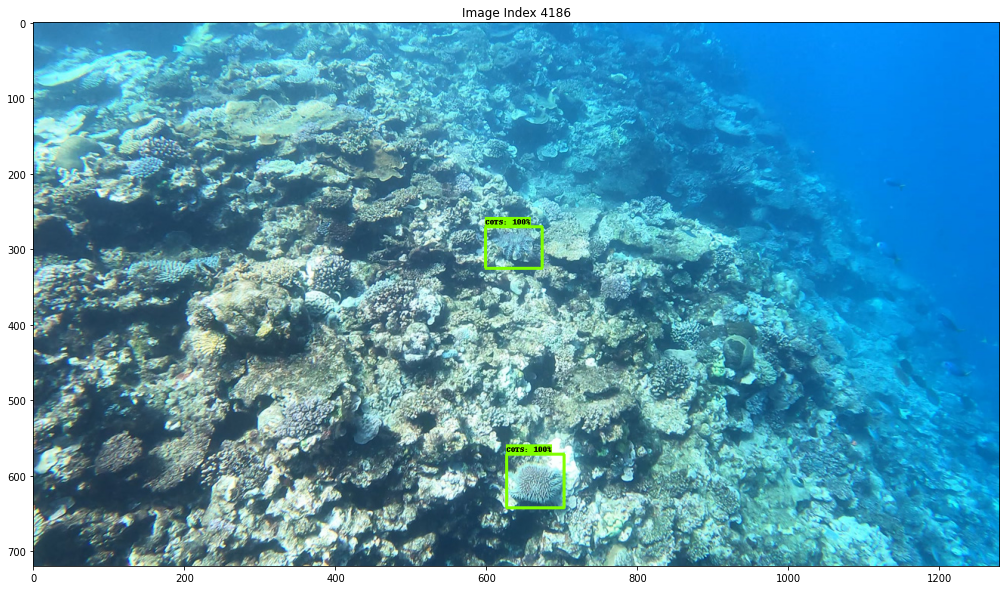

In [18]:
%matplotlib inline
idx = np.random.randint(0,train_data_df.shape[0]) 
img = get_image_with_annotation(train_data_df, idx)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.title(f"Image Index {idx}")
plt.show()

## Create TFRecord Files

In [19]:
def create_tf_example(row):
    with tf.io.gfile.GFile(row["image_path"], 'rb') as fid:
        encoded_jpg = fid.read()

    height = row["height"]
    width = row["width"]
    filename = f'{row["video_id"]}:{row["video_frame"]}'.encode('utf8') 
    image_format = 'jpeg'.encode() 

    bb = row["bboxes"]
    
    xmins = [i[1] for i in bb]
    xmaxs = [i[3] for i in bb]     
    ymins = [i[0] for i in bb] 
    ymaxs = [i[2] for i in bb] 
            
    classes_text = ['COTS'.encode() for i in bb]
    classes_id = [1 for i in bb] 

    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes_id),
    }))
    
    return tf_example.SerializeToString()


def convert_to_tfrecord(data_df, filename):
    with tf.io.TFRecordWriter(os.path.join(folders["DATA_PATH"],filename)) as writer:
        for _, row in tqdm(data_df.iterrows()):
            tf_example = create_tf_example(row)
            writer.write(tf_example)

In [20]:
convert_to_tfrecord(train_data_df, 'train.tfrec')
convert_to_tfrecord(val_data_df, 'valid.tfrec')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Create Label Map

In [21]:
labels = [{'name':'COTS', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')
        
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

## Test TFRecords

In [22]:
# def deserialize_example(serialized_string):
#     feature={
#       'image/height': tf.io.FixedLenFeature([], tf.int64),
#       'image/width': tf.io.FixedLenFeature([], tf.int64),
#       'image/filename': tf.io.FixedLenFeature([], tf.string),
#       'image/source_id': tf.io.FixedLenFeature([], tf.string),
#       'image/encoded': tf.io.FixedLenFeature([], tf.string),
#       'image/format': tf.io.FixedLenFeature([], tf.string),
#       'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
#       'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
#       'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
#       'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
#       'image/object/class/text': tf.io.VarLenFeature(tf.string),
#       'image/object/class/label': tf.io.VarLenFeature(tf.int64),
#     }

    
#     parsed_record = tf.io.parse_single_example(serialized_string, feature)
#     image = tf.io.decode_jpeg(parsed_record['image/encoded'])
#     xmins = tf.sparse.to_dense(parsed_record['image/object/bbox/xmin']).numpy()
#     xmaxs = tf.sparse.to_dense(parsed_record['image/object/bbox/xmax']).numpy()
#     ymins = tf.sparse.to_dense(parsed_record['image/object/bbox/ymin']).numpy()
#     ymaxs = tf.sparse.to_dense(parsed_record['image/object/bbox/ymax']).numpy()
    
#     bb = [[ymins[i], xmins[i], ymaxs[i], xmaxs[i]] for i in range(len(xmins))]

#     return image, bb

In [23]:
# train_set = tf.data.TFRecordDataset(os.path.join(folders["DATA_PATH"],"train.tfrec"))

In [24]:
# ds = train_set.take(1)
# for sample in ds:
#     image, bb = deserialize_example(sample)
    
# boxes = np.asarray(bb)
# num_boxes = len(boxes)

# img = plot_detections(np.array(image), boxes, np.ones(num_boxes, dtype='int32'), np.ones(num_boxes), category_index)
# plt.figure(figsize=(20,10))
# plt.imshow(img)
# plt.show()

In [25]:
# del train_set

# Config Model

In [26]:
!cp {os.path.join(folders['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(folders['CHECKPOINT_PATH'])}

In [27]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 768
       max_dimension: 768
       pad_to_max_dimension: true
     }
   }
   feature_extractor {
     type: "ssd_efficientnet-b2_bifpn_keras"
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: SWISH
       batch_norm {
         decay: 0.9900000095367432
         scale: true
         epsilon: 0.0010000000474974513
       }
       force_use_bias: true
     }
     bifpn {
       min_level: 3
       max_level: 7
       num_iterations: 5
       num_filters: 112
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 1.0
       x_scale: 1.0
       height_scale: 1.0
       width_scale: 1.0
     }
   }
   matcher {
     argmax_mat

In [28]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [29]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.model.ssd.image_resizer.keep_aspect_ratio_resizer.min_dimension = 1280
pipeline_config.model.ssd.image_resizer.keep_aspect_ratio_resizer.max_dimension = 1280
pipeline_config.train_config.data_augmentation_options[1].random_scale_crop_and_pad_to_square.output_size = 1280
pipeline_config.model.ssd.box_coder.faster_rcnn_box_coder.y_scale = 10.0
pipeline_config.model.ssd.box_coder.faster_rcnn_box_coder.x_scale = 10.0
pipeline_config.model.ssd.box_coder.faster_rcnn_box_coder.height_scale = 5.0
pipeline_config.model.ssd.box_coder.faster_rcnn_box_coder.width_scale = 5.0
pipeline_config.train_config.batch_size = 2
# pipeline_config.train_config.fine_tune_checkpoint = os.path.join(folders['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint = "../input/tfodtoutput/export7-D2-Plus10_000/export/checkpoint/ckpt-0"
pipeline_config.train_config.use_bfloat16 = False
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_config.sync_replicas = False
pipeline_config.train_config.replicas_to_aggregate = 1
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = 1e-3
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = 1e-4
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = 10000
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_steps = 2000
pipeline_config.model.ssd.post_processing.batch_non_max_suppression.score_threshold = 1e-8
pipeline_config.model.ssd.post_processing.batch_non_max_suppression.iou_threshold = 0.5
pipeline_config.train_config.num_steps = 10000
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(folders['DATA_PATH'], 'train.tfrec')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(folders['DATA_PATH'], 'valid.tfrec')]

In [30]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [31]:
!cat {files["PIPELINE_CONFIG"]}

model {
  ssd {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 1280
        max_dimension: 1280
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: "ssd_efficientnet-b2_bifpn_keras"
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: SWISH
        batch_norm {
          decay: 0.99
          scale: true
          epsilon: 0.001
        }
        force_use_bias: true
      }
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 5
        num_filters: 112
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
      

In [32]:
gc.collect()

3473

# Train Model

In [33]:
!python {files['TRAINING_SCRIPT']}\
    --model_dir={folders['CHECKPOINT_PATH']}\
    --pipeline_config_path={files['PIPELINE_CONFIG']}\
    --num_train_steps=10000

I1220 10:14:00.683878 139698610050880 mirrored_strategy.py:369] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1220 10:14:00.688749 139698610050880 config_util.py:552] Maybe overwriting train_steps: 10000
I1220 10:14:00.688920 139698610050880 config_util.py:552] Maybe overwriting use_bfloat16: False
I1220 10:14:00.699748 139698610050880 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b2
I1220 10:14:00.699903 139698610050880 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 112
I1220 10:14:00.700029 139698610050880 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet BiFPN num iterations: 5
I1220 10:14:00.704252 139698610050880 efficientnet_model.py:147] round_filter input=32 output=32
I1220 10:14:00.731512 139698610050880 cross_device_ops.py:621] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:

# Evaluate Model

In [34]:
!python {files['TRAINING_SCRIPT']}\
    --model_dir={folders['CHECKPOINT_PATH']}\
    --pipeline_config_path={files['PIPELINE_CONFIG']}\
    --checkpoint_dir={folders['CHECKPOINT_PATH']}\
    --eval_timeout=0 

W1220 14:16:24.378722 140197280216896 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
I1220 14:16:24.378973 140197280216896 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
I1220 14:16:24.379104 140197280216896 config_util.py:552] Maybe overwriting use_bfloat16: False
I1220 14:16:24.379217 140197280216896 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1220 14:16:24.379375 140197280216896 model_lib_v2.py:1111] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
I1220 14:16:26.501182 140197280216896 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b2
I1220 14:16:26.501523 140197280216896 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 112
I1220 14:16:26.502540 140197280216896 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet BiFPN nu

# Export Model

In [35]:
!python {files['EXPORTER_SCRIPT']}\
    --input_type image_tensor \
    --pipeline_config_path={files['PIPELINE_CONFIG']} \
    --trained_checkpoint_dir={folders['CHECKPOINT_PATH']} \
    --output_directory={folders['OUTPUT_PATH']}

I1220 14:21:45.772713 139815725352768 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b2
I1220 14:21:45.773007 139815725352768 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 112
I1220 14:21:45.773152 139815725352768 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet BiFPN num iterations: 5
I1220 14:21:45.777214 139815725352768 efficientnet_model.py:147] round_filter input=32 output=32
I1220 14:21:45.897468 139815725352768 efficientnet_model.py:147] round_filter input=32 output=32
I1220 14:21:45.897690 139815725352768 efficientnet_model.py:147] round_filter input=16 output=16
I1220 14:21:46.017396 139815725352768 efficientnet_model.py:147] round_filter input=16 output=16
I1220 14:21:46.017607 139815725352768 efficientnet_model.py:147] round_filter input=24 output=24
I1220 14:21:46.235355 139815725352768 efficientnet_model.py:147] round_filter input=24 output=24
I1220 14:21:46.235588 13

# Load Model from Checkpoints

In [36]:
!ls {folders["CHECKPOINT_PATH"]}/ckpt-*.index

my_models/my_efficientdet_d2/ckpt-10.index
my_models/my_efficientdet_d2/ckpt-11.index
my_models/my_efficientdet_d2/ckpt-5.index
my_models/my_efficientdet_d2/ckpt-6.index
my_models/my_efficientdet_d2/ckpt-7.index
my_models/my_efficientdet_d2/ckpt-8.index
my_models/my_efficientdet_d2/ckpt-9.index


In [37]:
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckps = glob.glob(folders["CHECKPOINT_PATH"]+"/ckpt-*.index")
ckps.sort(key=os.path.getmtime)

ckp_file = ckps[-1][:-6]
print(ckp_file)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(ckp_file).expect_partial()

def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

my_models/my_efficientdet_d2/ckpt-11


# Prediction

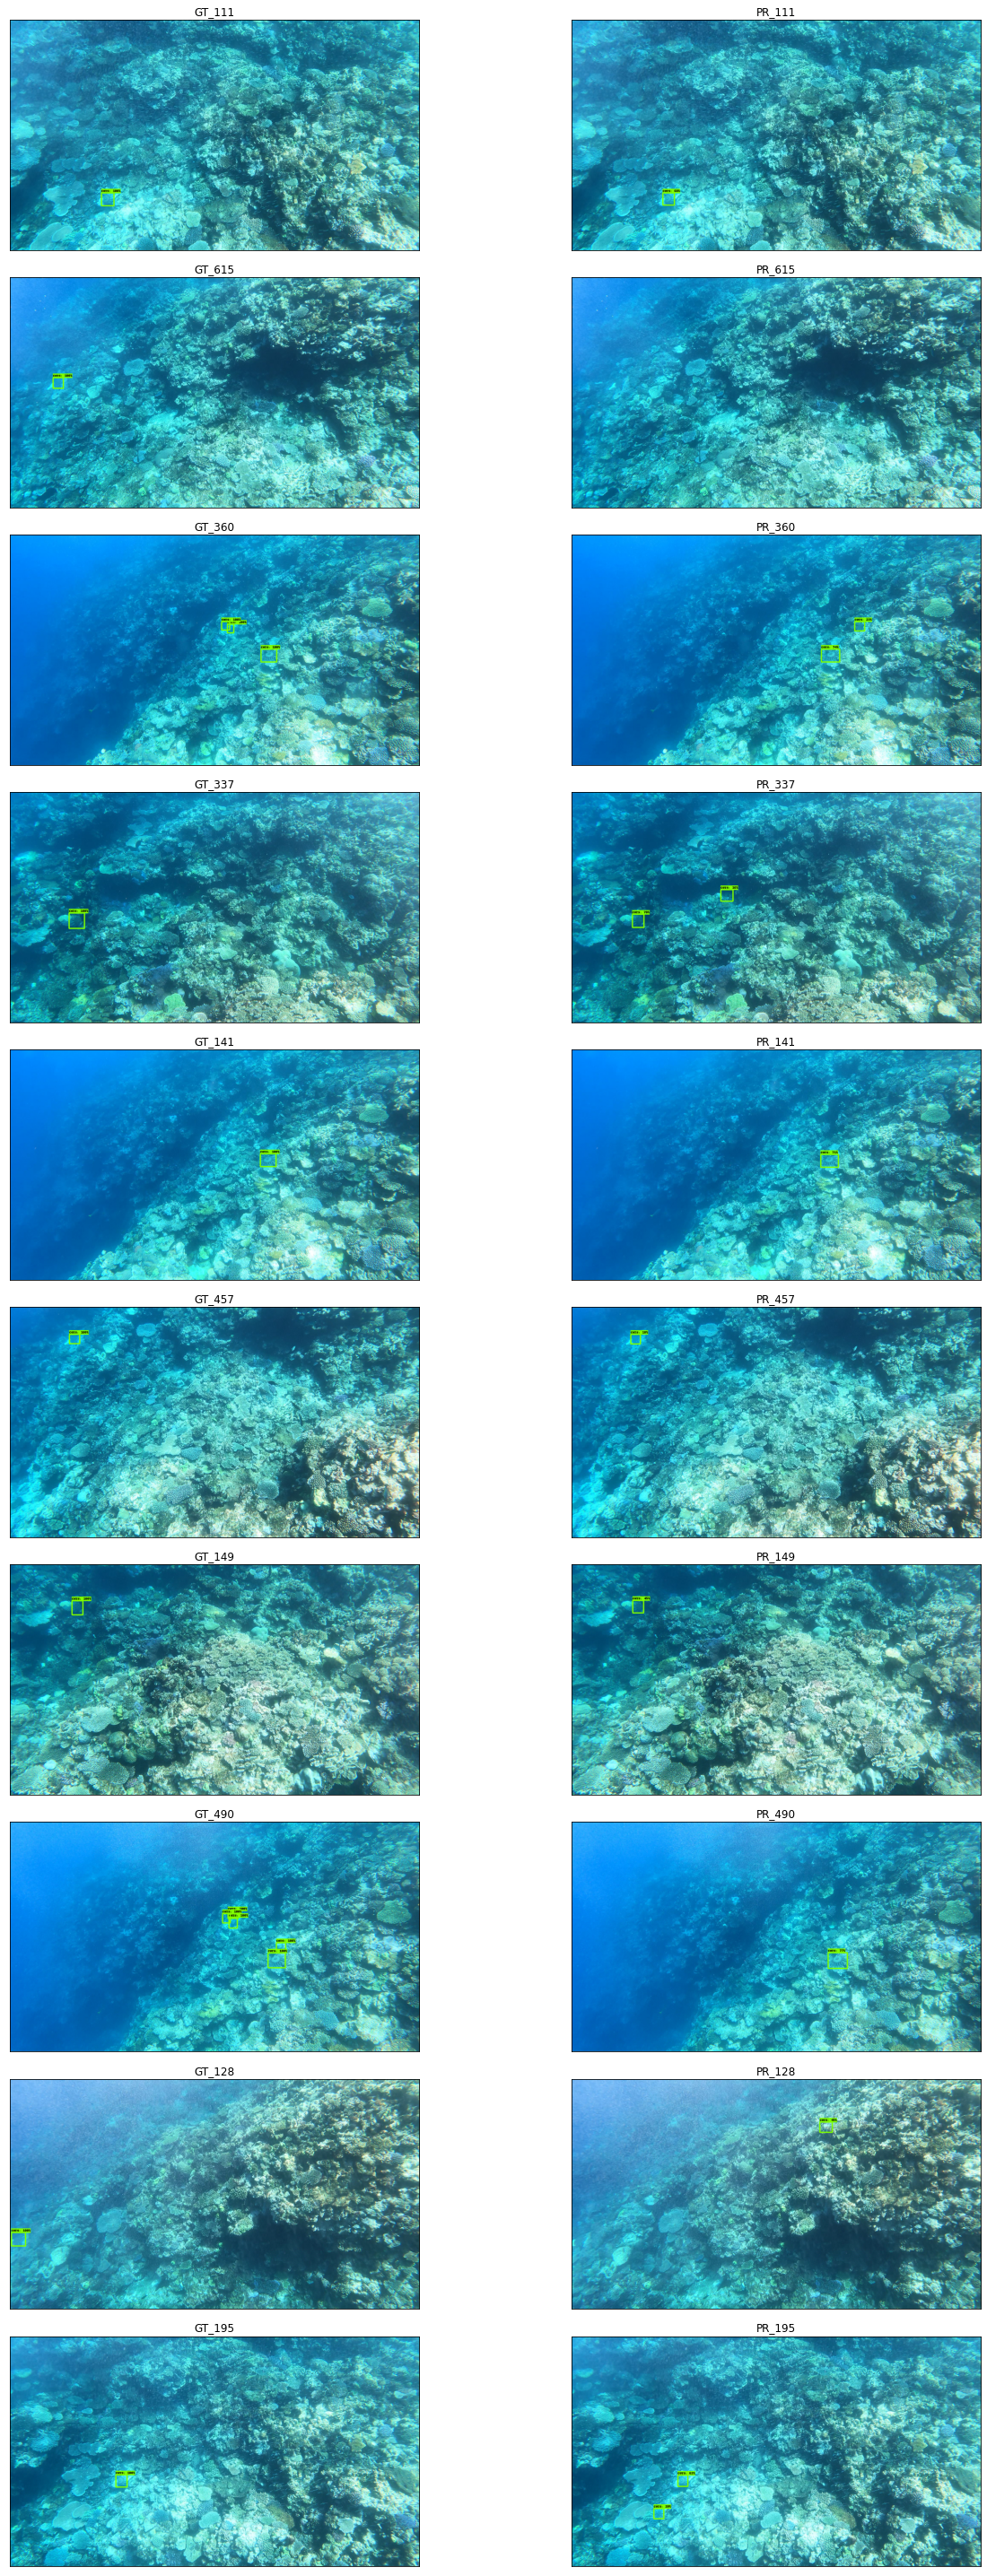

In [38]:
def get_image_pred(df, idx):

    image_np = load_image_into_np(df.iloc[idx].image_path)
    
    height, width, _ = image_np.shape
    input_tensor = tf.cast(np.expand_dims(image_np, 0), tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = detections['num_detections'][0].numpy().astype(np.int32) 
    bboxes = []
    scores = []
    classes = []
    DETECTION_THRESHOLD = 0.15
    
    for i in range(num_detections):
        score = detections['detection_scores'][0][i].numpy()
        
        if score < DETECTION_THRESHOLD:
            continue

        bboxes.append(list(detections['detection_boxes'][0][i].numpy()))
        scores.append(score)
        classes.append(1)
    img = plot_detections(image_np, np.array(bboxes), np.array(classes), np.array(scores), category_index, unc=True)
    return img

cnt = 10
fig, ax = plt.subplots(cnt, 2, figsize = (20,40))
for row in range(cnt):
    idx = np.random.randint(0,val_data_df.shape[0])
    gt = get_image_with_annotation(val_data_df, idx)
    pred = get_image_pred(val_data_df, idx)
    
    ax[row][0].imshow(gt)
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f"GT_{idx}")
    
    ax[row][1].imshow(pred)
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f"PR_{idx}")
plt.tight_layout()
plt.show()

In [39]:
!zip ./my_model.zip -r {folders["OUTPUT_PATH"]}

  adding: my_models/my_efficientdet_d2/export/ (stored 0%)
  adding: my_models/my_efficientdet_d2/export/saved_model/ (stored 0%)
  adding: my_models/my_efficientdet_d2/export/saved_model/saved_model.pb (deflated 93%)
  adding: my_models/my_efficientdet_d2/export/saved_model/assets/ (stored 0%)
  adding: my_models/my_efficientdet_d2/export/saved_model/variables/ (stored 0%)
  adding: my_models/my_efficientdet_d2/export/saved_model/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: my_models/my_efficientdet_d2/export/saved_model/variables/variables.index (deflated 78%)
  adding: my_models/my_efficientdet_d2/export/checkpoint/ (stored 0%)
  adding: my_models/my_efficientdet_d2/export/checkpoint/ckpt-0.data-00000-of-00001 (deflated 25%)
  adding: my_models/my_efficientdet_d2/export/checkpoint/ckpt-0.index (deflated 81%)
  adding: my_models/my_efficientdet_d2/export/checkpoint/checkpoint (deflated 42%)
  adding: my_models/my_efficientdet_d2/export/pipeline.config (deflated 68

<a href="./my_models.zip"> Download File my_model.zip </a>

# Submission

In [40]:
env = greatbarrierreef.make_env()  
iter_test = env.iter_test() 

In [41]:
DETECTION_THRESHOLD = 0.15

for (image_np, df) in iter_test:
    height, width, _ = image_np.shape
    
    input_tensor = tf.cast(np.expand_dims(image_np, 0), tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = detections['num_detections'][0].numpy().astype(np.int32)
    predictions = []
    
    for index in range(num_detections):
        score = detections['detection_scores'][0][index].numpy()

        if score < DETECTION_THRESHOLD:
            continue

        bbox = detections['detection_boxes'][0][index].numpy()
        y_min = int(bbox[0] * height)
        x_min = int(bbox[1] * width)
        y_max = int(bbox[2] * height)
        x_max = int(bbox[3] * width)

        bbox_width = x_max - x_min
        bbox_height = y_max - y_min

        predictions.append(f'{score:.2f} {x_min} {y_min} {bbox_width} {bbox_height}')
        
        
    prediction_str = ' '.join(predictions)
    df['annotations'] = prediction_str
    env.predict(df)

sub_df = pd.read_csv('submission.csv')
sub_df.head()

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


index         annotations
0      0  0.17 205 146 36 30
1      1  0.18 200 148 37 30
2      2  0.18 198 150 34 29

In [42]:
!rm -rf ./api
!rm -rf ./data
!rm -rf ./pre-trained-models